### Importing all libraries

In [1]:
#Importing audio file paths
import os

#For managing dataframe
import pandas as pd
import numpy as np

#PyTorch
import torchaudio
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from torch import nn

#Metrics
import seaborn as sb
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import ConfusionMatrix

# Misc.
import warnings
import librosa
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm_notebook
from IPython.display import Audio

warnings.filterwarnings("ignore")

#Selecting device
device="cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device}")

Using cuda


### Recursively get all audio files

In [2]:
def audio_fetch(src,audio_paths):
    l=os.listdir(src)
    if(len(l)!=0):
        for i in range(len(l)):
            if(".wav" in l[i] or ".mp3" in l[i] or ".aac" in l[i]):
                audio_paths.append(str(src+l[i]))
            elif("." not in l[i]):
                try:
                    audio_fetch(str(src+"/"+l[i]+"/"),audio_paths)
                except:
                    continue
                            
# For getting all possible classes along with their label encoding as a dictionary
def class_fetch(df: pd.DataFrame())->(list,dict):
    s=sorted(df[1].unique())
    
    toDel=[i for i in dict(df[1].value_counts(sort=True)).keys() if dict(df[1].value_counts(sort=True))[i]<3]
    for i in toDel:
        s.remove(i)
    d={}
    
    toDel_ids=[]
    for i in toDel:
        toDel_ids.extend(list(df[df[1]==i][0].values))
    
    
    count=0
    for i in s:
        d[i]=count
        count+=1
    return list(s),d, toDel_ids

### Dataset Class

In [3]:
def extract_process(data, sample_rate):
    output_result = np.array([])

    mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    output_result = np.hstack((output_result, mean_zero))

    
    stft_out = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, chroma_stft))

    mfcc_out = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    output_result = np.hstack((output_result, mfcc_out))

    root_mean_out = np.mean(librosa.feature.rms(y=data).T, axis=0)
    output_result = np.hstack((output_result, root_mean_out))

    mel_spectogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, mel_spectogram))
    

    return output_result

class audio_dataset(Dataset):
    def __init__(self,
                 info: str,
                 audio_path=None,
                 audio_files=None,
                 header=None) -> None:
        
        self.paths=[]

        if (audio_path==None and audio_files==None):
            raise Exception("Both audio_path and audio_files cannot be None at the same time")

        if(audio_files==None):
            audio_fetch(audio_path,self.paths)
        else:
            self.paths=audio_files
        
        self.patient=dict()
        self.paths.sort() 
        
        # We are going to remove all classes than 2 patient data

        for i in self.paths:
            index=int(i.split("/")[-1].split("_")[0])
            self.patient[index]=[]
        
        for i in range(len(self.paths)):
            self.patient[int(self.paths[i].split("/")[-1].split("_")[0])].append(self.paths[i])
        
        self.info_df=pd.read_csv(info,header=header)
        self.classes, self.class_to_idx, self.ids_to_remove = class_fetch(self.info_df)

        # After getting the patient ids to remove all the data from patient list is removed
        for i in self.ids_to_remove:
            if i in self.patient.keys():
                self.patient.pop(i)

        #Denotes sequence of audio files for a particular patient
        self.sequence=list(self.patient.values())

        # Audio path is updated after removing classing with small number of patients
        self.paths=[]
        for i in self.sequence:
            if(i!=[]):
                for j in i:
                    self.paths.append(j)

        self.scaler=StandardScaler()

    
    def get_class(self,file: str):
        return self.info_df[self.info_df[0]==int(file.split("/")[-1].split("_")[0])][1].values[0]
    
    def __len__(self) -> int:
        return len(self.paths)


    def __getitem__(self, index: int) -> torch.Tensor():
        self.val=self.paths[index]
        self.class_val=self.class_to_idx[self.get_class(self.val)]

        self.signal, self.sr = librosa.load(self.val)
        self.signal = torch.unsqueeze(torch.from_numpy(np.squeeze(self.scaler.fit_transform(np.reshape(extract_process(self.signal, self.sr),newshape=(-1,1))))),dim=0).type(torch.float32)

        return self.signal,self.class_val

##### Testing audio dataset

In [4]:
ds=audio_dataset(audio_path="../Sound_Classification/archive/Respiratory_Sound_Database/",info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv")
ds.class_to_idx

{'Bronchiectasis': 0,
 'Bronchiolitis': 1,
 'COPD': 2,
 'Healthy': 3,
 'Pneumonia': 4,
 'URTI': 5}

In [5]:
print(len(ds.sequence))
print(ds.get_class(ds.paths[3]))

123
COPD


### Dataloader

In [6]:
BATCH_SIZE=32

ds=[]
audio_fetch("../Sound_Classification/archive/respiratory_sound_database/",ds)

# Perform train test split
train_ds,temp_ds=train_test_split(ds,test_size=0.4)
test_ds,val_ds=train_test_split(temp_ds,test_size=0.5)

print(f"Before trimming:")
print(f"No. of audio files in train_ds: {len(train_ds)}\nNo. of audio files in test_ds: {len(test_ds)}\nNo. of audio files in val_ds: {len(val_ds)}")

train_ds=audio_dataset(audio_files=train_ds,info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv")
test_ds=audio_dataset(audio_files=test_ds,info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv")
val_ds=audio_dataset(audio_files=val_ds,info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv")

print(f"\nAfter trimming:")
print(f"No. of audio files in train_ds: {train_ds.__len__()}\nNo. of audio files in test_ds: {test_ds.__len__()}\nNo. of audio files in val_ds: {val_ds.__len__()}")

train_loader=torch.utils.data.DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=True)
val_loader=torch.utils.data.DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=True)

Before trimming:
No. of audio files in train_ds: 552
No. of audio files in test_ds: 184
No. of audio files in val_ds: 184

After trimming:
No. of audio files in train_ds: 550
No. of audio files in test_ds: 183
No. of audio files in val_ds: 184


##### Checking dataloader

In [7]:
im=next(iter(train_loader))[0]
im.shape

torch.Size([32, 1, 182])

In [8]:
im[0].dtype

torch.float32

In [9]:
assert ((train_ds.classes==test_ds.classes and test_ds.classes==val_ds.classes))

### Setting up Tensorboard and performance metrics

In [10]:
log_dir = "../"+"performance"
writer = SummaryWriter(log_dir=log_dir)

def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)

f1_fn=MulticlassF1Score(num_classes=len(train_ds.classes)).to(device)
cf_matrix=ConfusionMatrix(num_classes=len(train_ds.classes),task="multiclass")

### Model 1 (Simple Conv1D Network)

In [11]:
class auditory_transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_embedding=nn.Sequential(nn.Conv1d(in_channels=1,out_channels=256,stride=1,kernel_size=5),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Conv1d(in_channels=256,out_channels=256,kernel_size=4),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=1,padding=1),
                                           nn.Conv1d(in_channels=256,out_channels=128,kernel_size=4),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Conv1d(in_channels=128,out_channels=64,kernel_size=4),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Conv1d(in_channels=64,out_channels=32,kernel_size=5),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Dropout(p=0.2),
                                           nn.Flatten(),
                                           nn.ReLU(),
                                           nn.Linear(in_features=192,out_features=32,bias=True),
                                           nn.ReLU(),
                                           nn.Dropout(p=0.3),
                                           nn.Linear(in_features=32,out_features=len(train_ds.classes),bias=True))

    def forward(self,x):
        return self.input_embedding(x)

#### Model 1 testing and training

In [12]:
next(iter(train_loader))[0].shape

torch.Size([32, 1, 182])

In [13]:
model=auditory_transformer().to(device)
with torch.inference_mode():
    print(model((next(iter(train_loader))[0]).to(device)).shape)

torch.Size([32, 6])


##### Optimizer and loss function

In [14]:
def get_class_weight(ds: audio_dataset) -> torch.Tensor():
    y=[]
    for i in range(ds.__len__()):
        y.append(ds.get_class(ds.paths[i]))
    class_weights = compute_class_weight('balanced', classes=ds.classes, y=y)
    return torch.from_numpy(class_weights).type(torch.float32).to(device)

optimizer=torch.optim.Adam(params=model.parameters())
loss_fn=nn.CrossEntropyLoss(weight=get_class_weight(train_ds))

print(f"Taking class weights:\n{get_class_weight(train_ds)}\n{train_ds.classes}")

Taking class weights:
tensor([10.1852, 11.4583,  0.1926,  4.8246,  3.8194,  6.5476], device='cuda:0')
['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']


##### Training Function

In [15]:
def train_model(model,epochs):
    for i in tqdm_notebook(range(epochs)):
        train_preds=torch.tensor([])
        test_preds=torch.tensor([])
        train_actual=torch.tensor([])
        test_actual=torch.tensor([])
        
        print("\nTraining:")
        model.train()
        
        #Defining accuracy and loss for train and test data
        temp_train_accuracy=[]
        temp_test_accuracy=[]
        temp_train_loss=[]
        temp_test_loss=[]
        temp_train_f1=[]
        temp_test_f1=[]
    
        net_train_accuracy=0
        net_test_accuracy=0
        net_train_loss=0
        net_test_loss=0
        net_train_f1=0
        net_test_f1=0
        
        with tqdm_notebook(total=len(train_loader)) as pbar:
            for x,y in train_loader:
                    x=x.to(device)
                    y=y.to(device)
        
                    #Calculating model output
                    logits=model(x)
        
                    #Reseting any old gradient values
                    optimizer.zero_grad()
                    loss=loss_fn(logits.squeeze(),y)
                
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    train_preds=torch.hstack((train_preds,preds.to("cpu")))
                    train_actual=torch.hstack((train_actual,y.to("cpu")))
                    accuracy_train=accuracy_fn(logits.type(torch.float32),y)
                    f1_train=f1_fn(preds,y)
                    temp_train_accuracy.append(accuracy_train)
                    temp_train_loss.append(loss.item())
                    temp_train_f1.append(f1_train.item())
                
                    #Back Propogation
                    loss.backward()
                
                    #Update Parameters
                    optimizer.step()
                
                    #Progress Bar Update
                    pbar.update(1)
            pbar.close()
        #Tensorboard & Metrics for the dataset
        net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
        net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
        net_train_f1=sum(temp_train_f1)/len(temp_train_f1)
        writer.add_scalar("Train Accuracy",net_train_accuracy,i)
        writer.add_scalar("Train Loss",net_train_loss,i)
        writer.add_scalar("Train F1 Score",net_train_f1)
    
        #Evaluation
        print("Testing:")
        model.eval()
    
        with tqdm_notebook(total=len(test_loader)) as pbar2:
            for x,y in test_loader:
                x=x.to(device)
                y=y.to(device)
                
                #Setting inference mode
                with torch.inference_mode():
                    logits=model(x)
                    loss=loss_fn(logits.squeeze().type(torch.float32),y)
    
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    test_preds=torch.hstack((test_preds,preds.to("cpu")))
                    test_actual=torch.hstack((test_actual,y.to("cpu")))
                    accuracy_test=accuracy_fn(logits,y)
                    f1_test=f1_fn(preds,y)
                    temp_test_accuracy.append(accuracy_test)
                    temp_test_loss.append(loss.item())
                    temp_test_f1.append(f1_test.item())
    
                    #Progress Bar Update
                    pbar2.update(1)
            pbar2.close()
    
        #Tensorboard & Metrics for the dataset
        net_test_accuracy=sum(temp_test_accuracy)/len(temp_test_accuracy)
        net_test_loss=sum(temp_test_loss)/len(temp_test_loss)
        net_test_f1=sum(temp_test_f1)/len(temp_test_f1)
        writer.add_scalar("Test Accuracy",net_test_accuracy,i)
        writer.add_scalar("Test Loss",net_test_loss,i)
        writer.add_scalar("Test F1 Score",net_test_f1,i)

        '''
        #Saving the model
        try:
            os.makedirs(f"./{model_name}_feature_extractor/")
        except Exception as e:
            pass
        torch.save(model.state_dict(),f"./{model_name}_feature_extractor/checkpoint-{i+1}.pth")
        '''
        
        print(f"\nEpoch {i+1}:\n\nTrain Accuracy: {net_train_accuracy}\n\nTrain Loss: {net_train_loss}\n\nTrain F1 Score: {net_train_f1}\n\nTest Accuracy: {net_test_accuracy}\n\nTest Loss: {net_test_loss}\n\nTest F1 Score: {net_test_f1}")

        #Plotting confusion matrix
        print("\n")
        plt.figure(figsize=(10,5))
        sb.heatmap(cf_matrix(train_preds,train_actual),annot=True,xticklabels=train_ds.classes,yticklabels=train_ds.classes)
        plt.title("Train confusion matrix")
        plt.xlabel("Predictions")
        plt.ylabel("True")
        plt.show()
        
        print("\n")
        plt.figure(figsize=(10,5))
        sb.heatmap(cf_matrix(test_preds,test_actual),annot=True,xticklabels=train_ds.classes,yticklabels=train_ds.classes)
        plt.title("Test confusion matrix")
        plt.xlabel("Predictions")
        plt.ylabel("True")
        plt.show()

##### Training Model 1

  0%|          | 0/30 [00:00<?, ?it/s]


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 1:

Train Accuracy: 0.3998842592592593

Train Loss: 1.8013641370667353

Train F1 Score: 0.14307999719555178

Test Accuracy: 0.5047554347826088

Test Loss: 1.7533508737881978

Test F1 Score: 0.17155043904980025




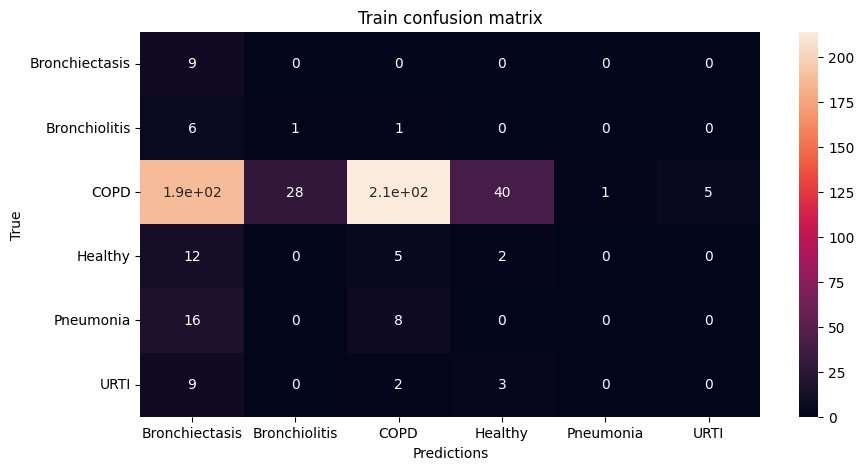

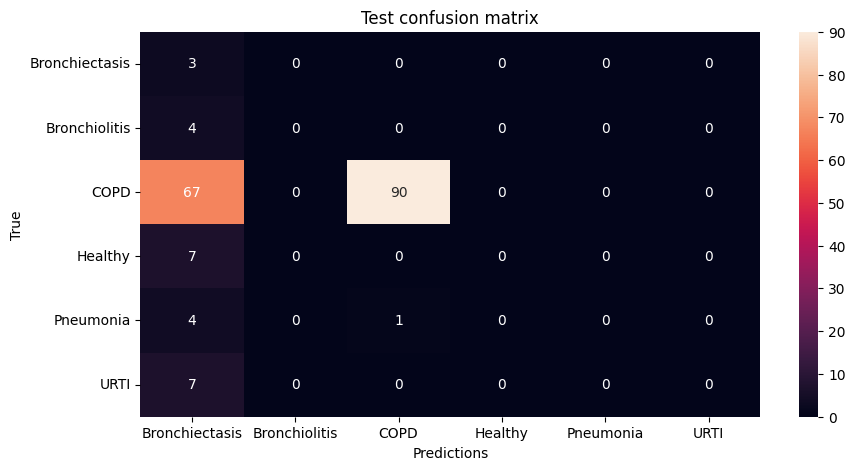


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 2:

Train Accuracy: 0.5503472222222222

Train Loss: 1.7034231358104281

Train F1 Score: 0.17850503159893882

Test Accuracy: 0.6845561594202899

Test Loss: 1.6297898292541504

Test F1 Score: 0.2413118282953898




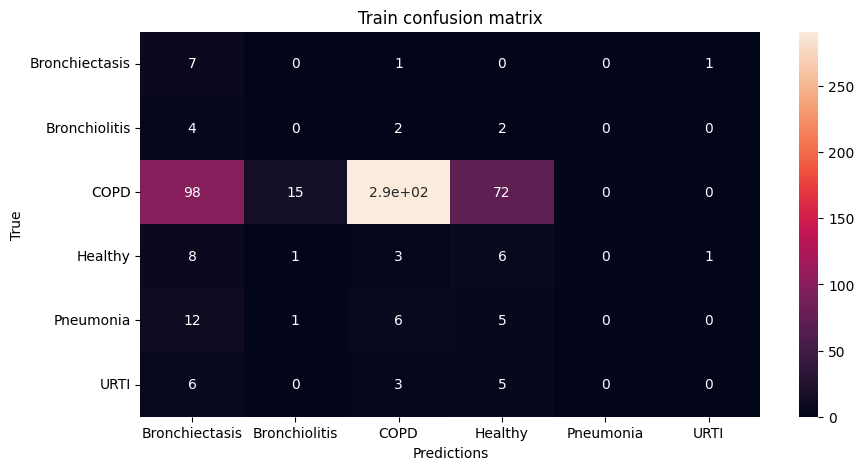

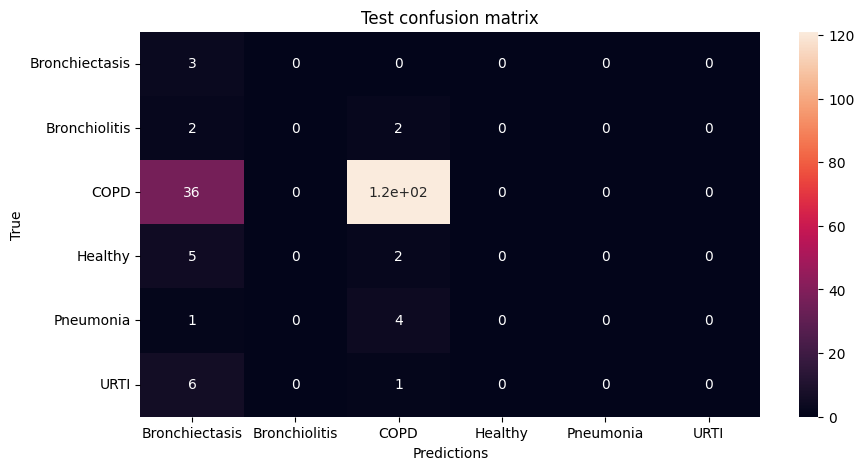


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 3:

Train Accuracy: 0.6134259259259259

Train Loss: 1.6849925385581122

Train F1 Score: 0.1849779321087731

Test Accuracy: 0.6918025362318841

Test Loss: 1.6281548341115315

Test F1 Score: 0.24676159769296646




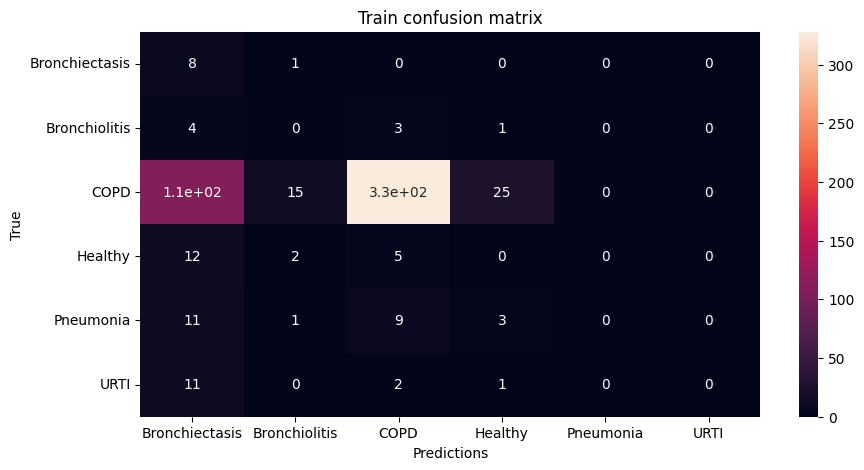

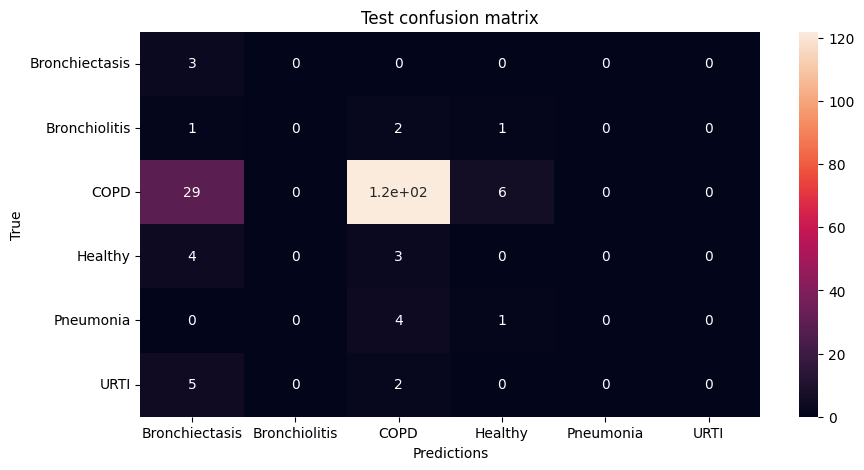


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 4:

Train Accuracy: 0.6365740740740741

Train Loss: 1.6161380575762854

Train F1 Score: 0.20834588756163916

Test Accuracy: 0.5545742753623188

Test Loss: 1.6776477098464966

Test F1 Score: 0.19835651417573294




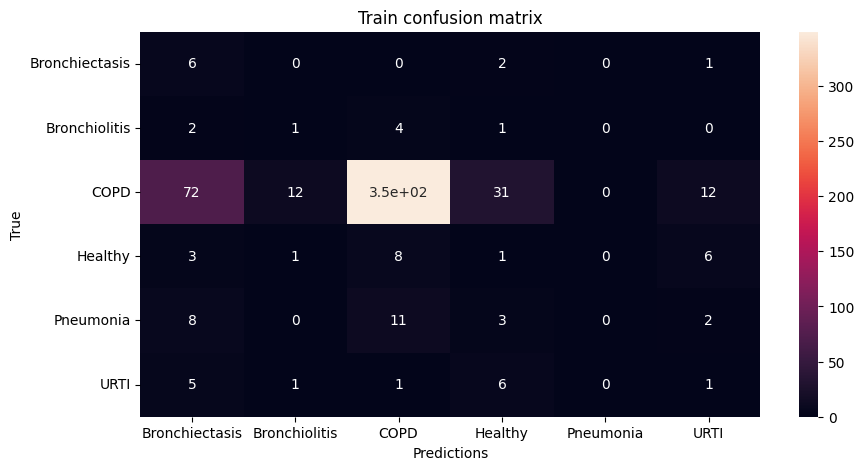

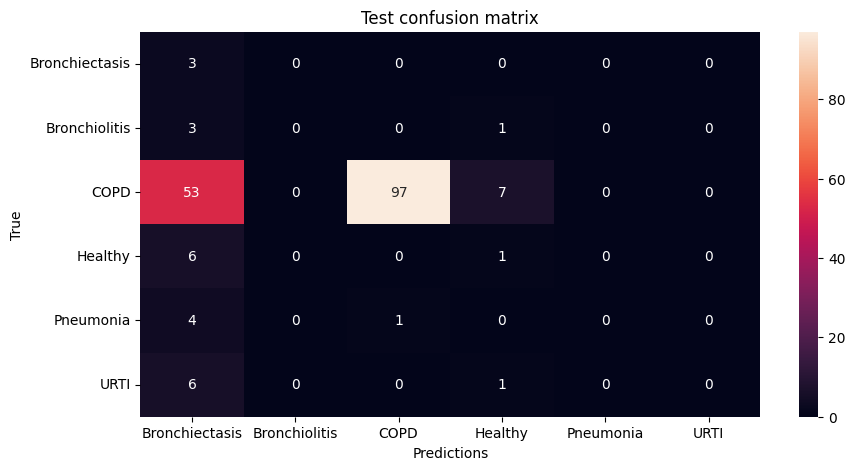


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 5:

Train Accuracy: 0.5543981481481481

Train Loss: 1.6793122424019709

Train F1 Score: 0.20298469770285818

Test Accuracy: 0.6628170289855072

Test Loss: 1.4747387965520222

Test F1 Score: 0.26616456856330234




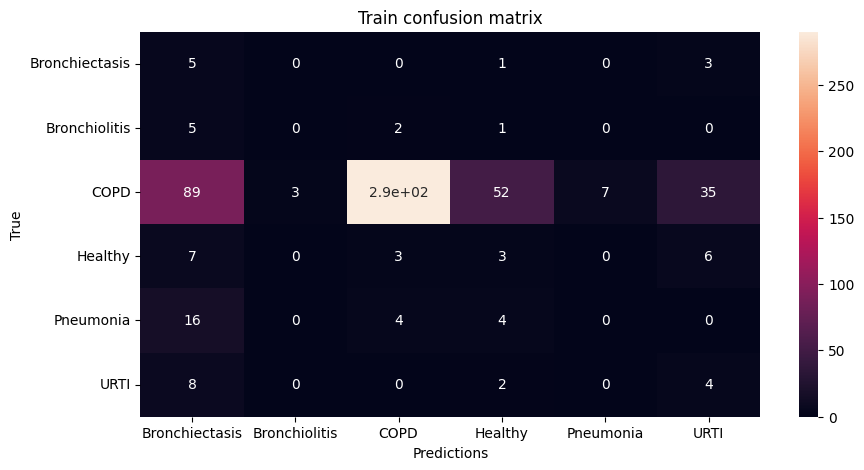

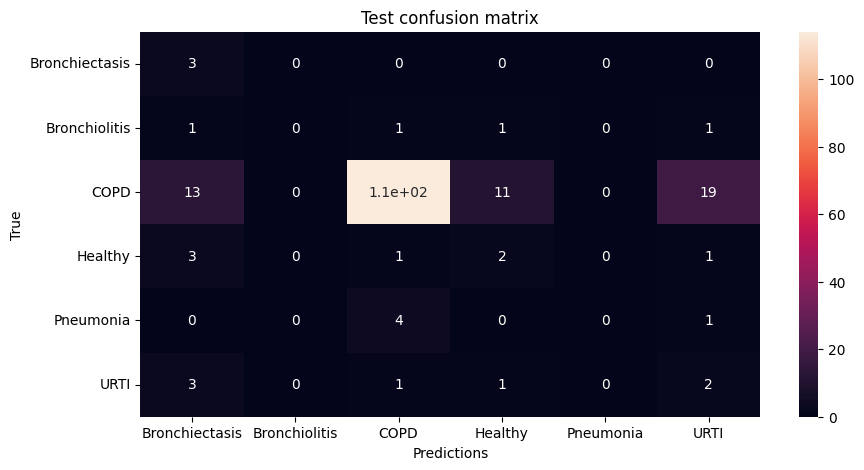


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 6:

Train Accuracy: 0.6290509259259259

Train Loss: 1.5779997143480513

Train F1 Score: 0.2061003479692671

Test Accuracy: 0.6752717391304347

Test Loss: 1.5907578865687053

Test F1 Score: 0.21524662772814432




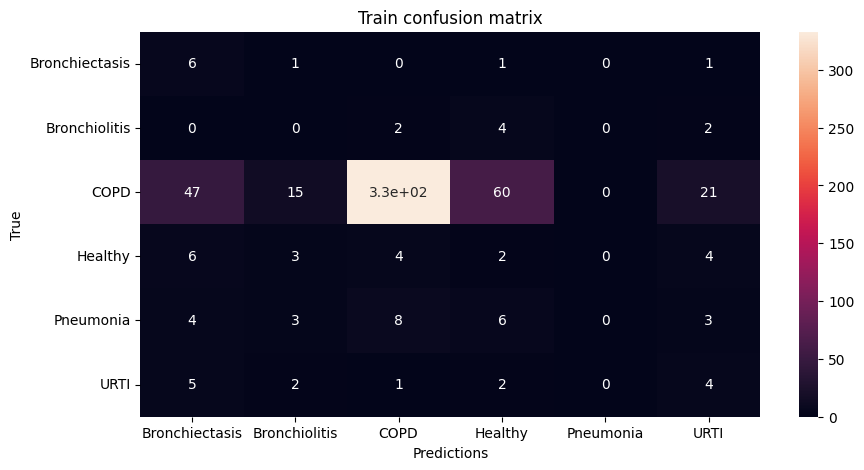

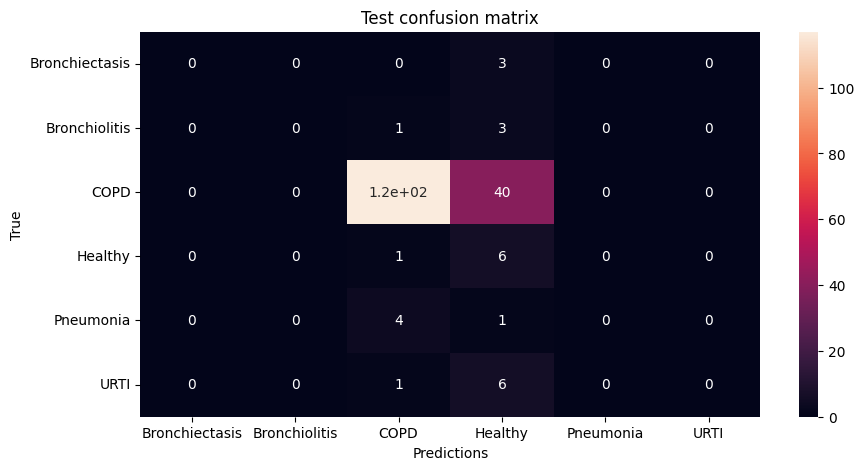


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 7:

Train Accuracy: 0.6105324074074074

Train Loss: 1.6384051276577845

Train F1 Score: 0.19656594759888119

Test Accuracy: 0.5733695652173912

Test Loss: 1.6528188188870747

Test F1 Score: 0.23969308038552603




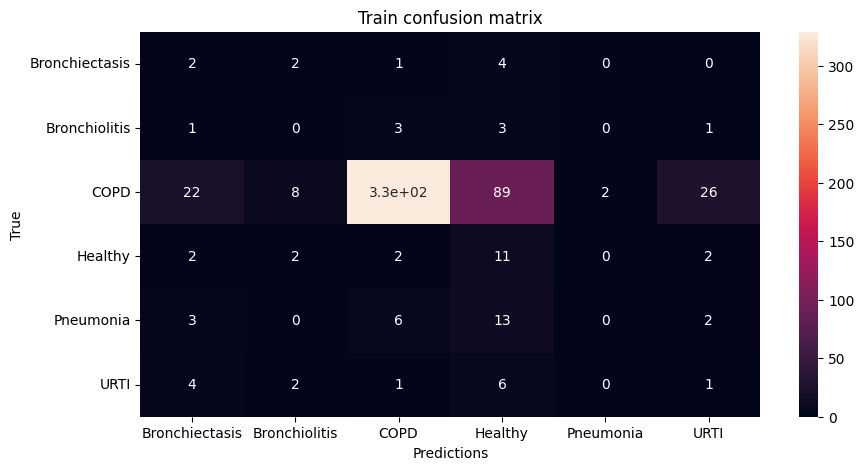

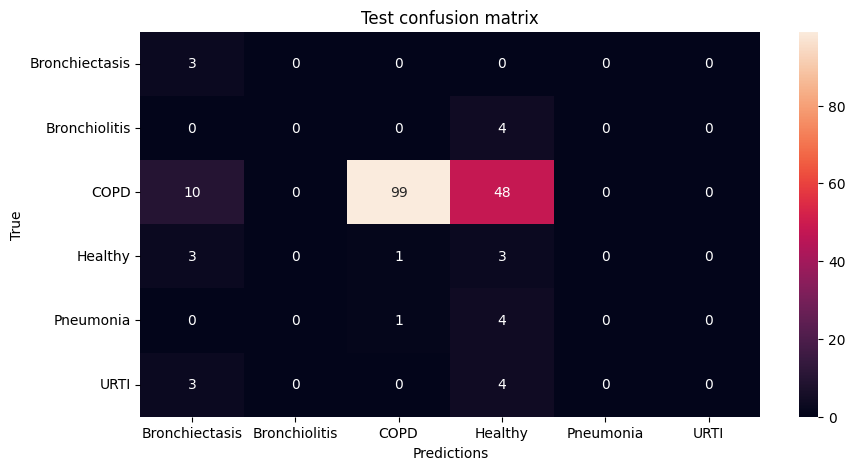


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 8:

Train Accuracy: 0.6134259259259259

Train Loss: 1.654005269209544

Train F1 Score: 0.18593664757079548

Test Accuracy: 0.641983695652174

Test Loss: 1.594261070092519

Test F1 Score: 0.24101139605045319




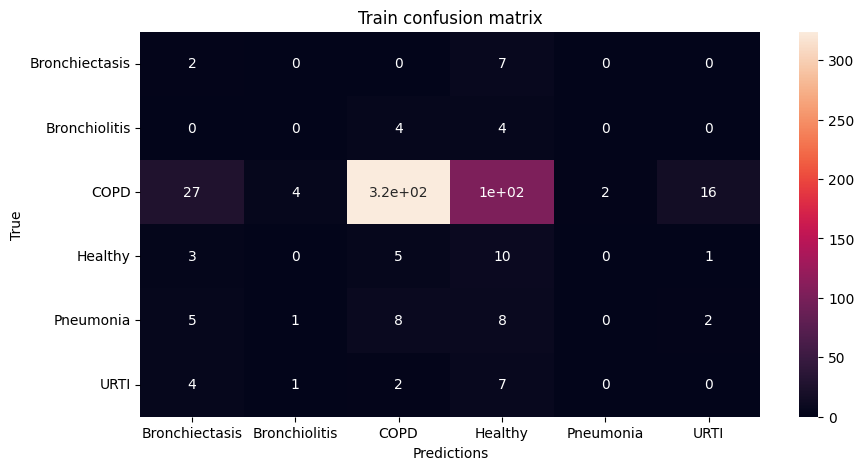

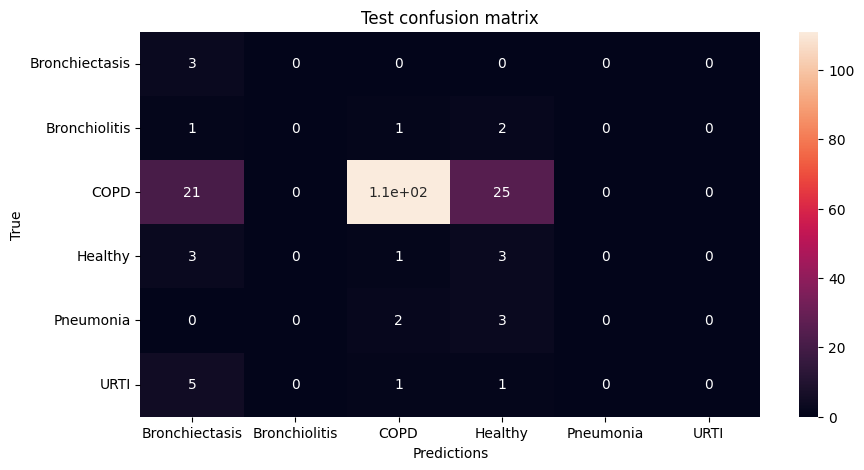


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 9:

Train Accuracy: 0.6041666666666666

Train Loss: 1.6492583089404635

Train F1 Score: 0.18299183083905113

Test Accuracy: 0.6752717391304347

Test Loss: 1.5646948615709941

Test F1 Score: 0.25948114693164825




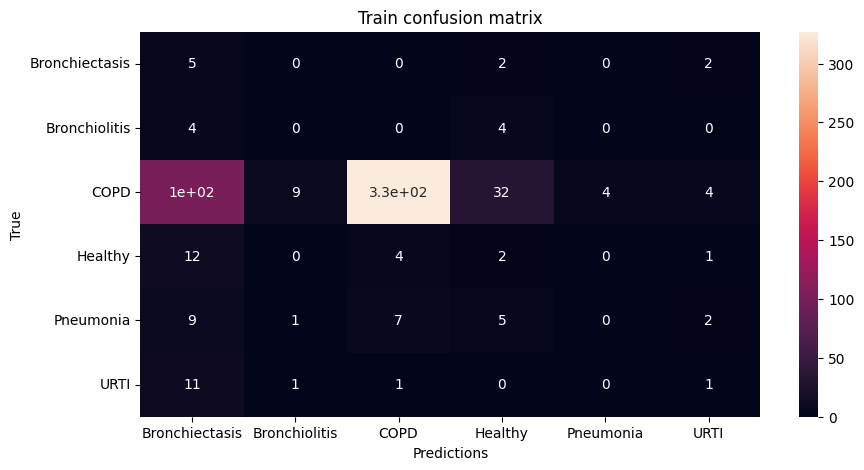

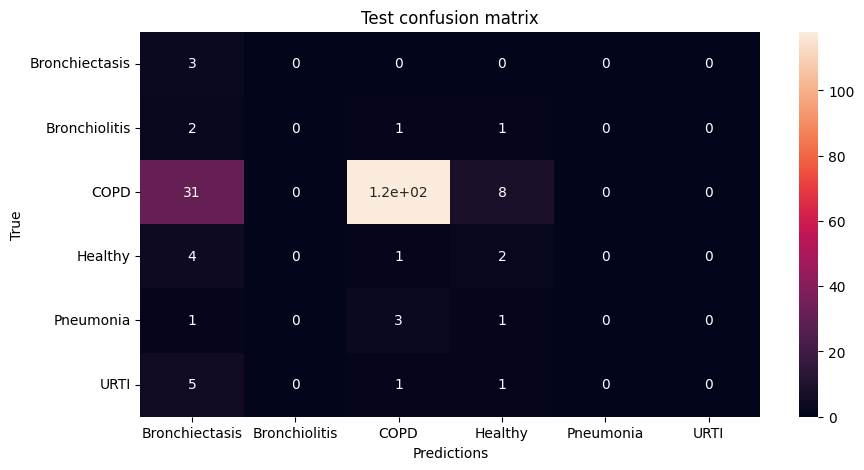


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 10:

Train Accuracy: 0.6163194444444444

Train Loss: 1.6110464996761746

Train F1 Score: 0.19613534046543968

Test Accuracy: 0.630661231884058

Test Loss: 1.5084287921587627

Test F1 Score: 0.23377183576424918




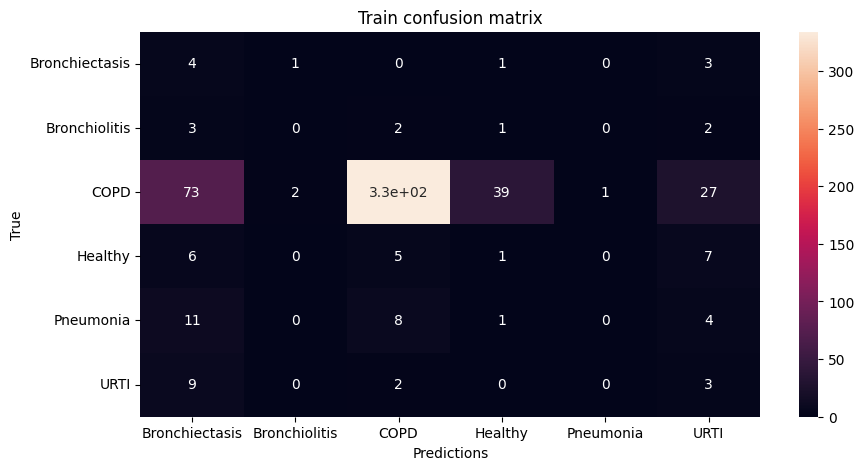

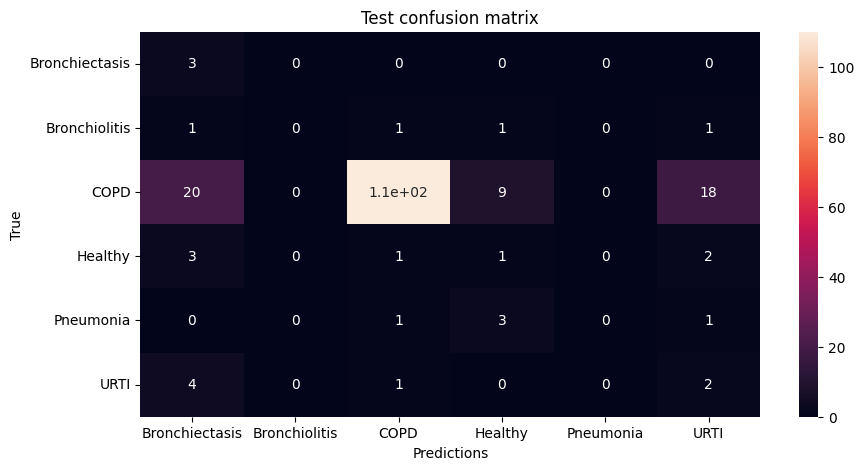


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 11:

Train Accuracy: 0.6006944444444444

Train Loss: 1.6238105760680304

Train F1 Score: 0.19344687875774172

Test Accuracy: 0.5849184782608695

Test Loss: 1.6063367525736492

Test F1 Score: 0.1701176861921946




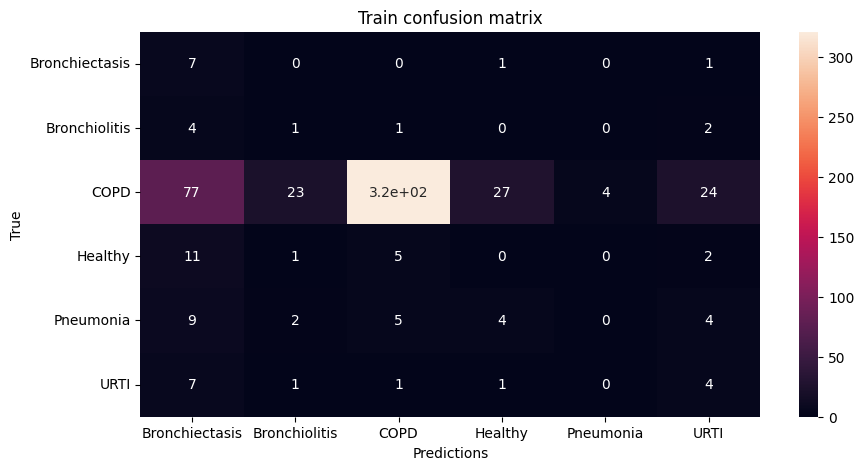

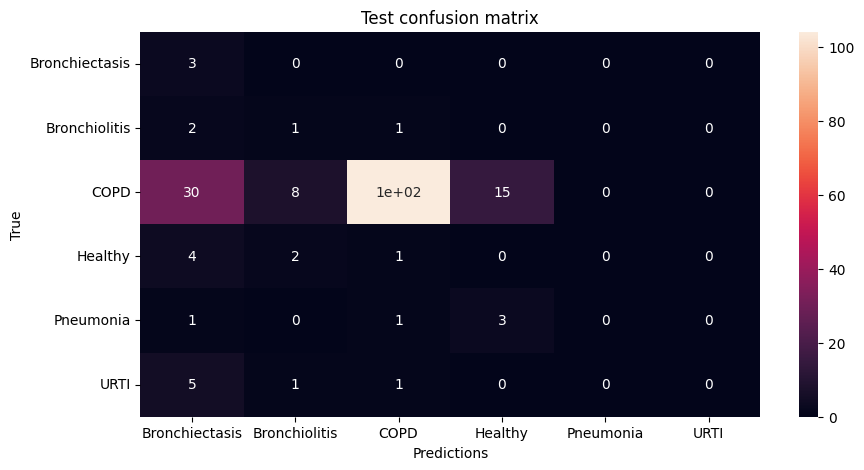


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 12:

Train Accuracy: 0.6099537037037037

Train Loss: 1.6287433438830905

Train F1 Score: 0.19443835732009676

Test Accuracy: 0.6501358695652174

Test Loss: 1.539993981520335

Test F1 Score: 0.2260185331106186




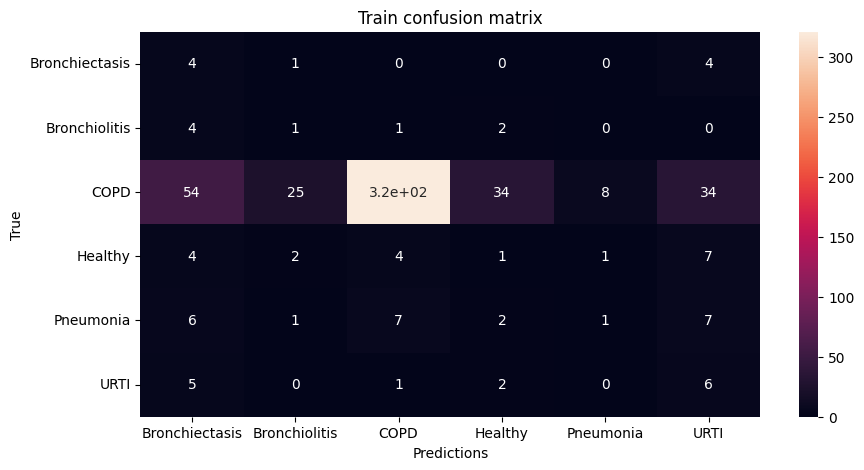

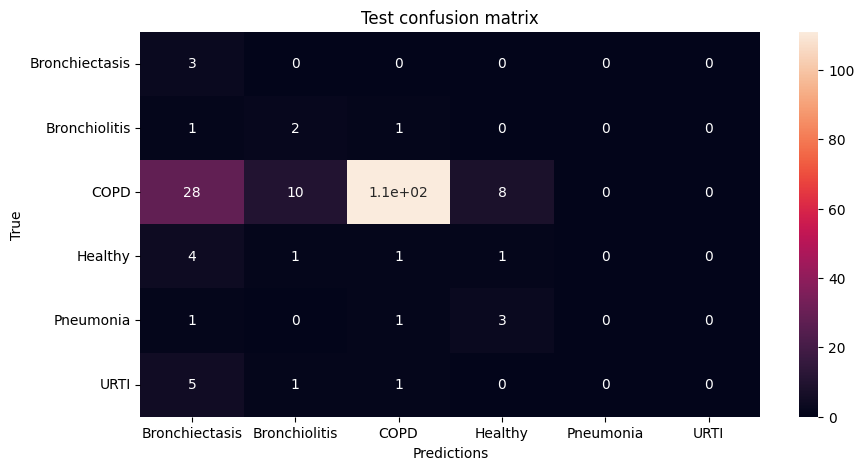


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 13:

Train Accuracy: 0.6284722222222222

Train Loss: 1.6165813936127558

Train F1 Score: 0.17202634943856132

Test Accuracy: 0.5973731884057971

Test Loss: 1.584447721640269

Test F1 Score: 0.22483966872096062




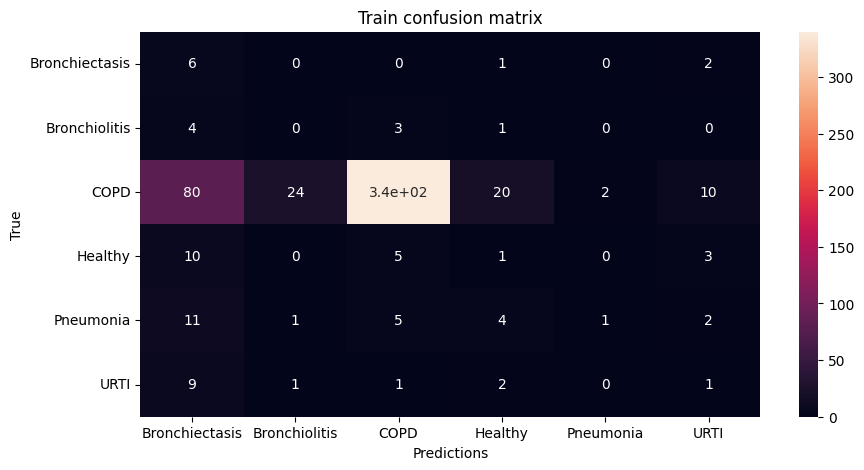

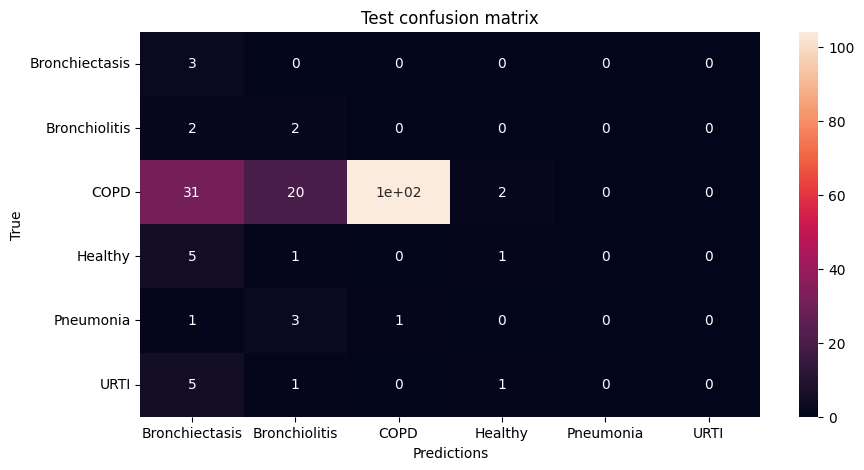


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 14:

Train Accuracy: 0.5943287037037037

Train Loss: 1.567099882496728

Train F1 Score: 0.19458270404073927

Test Accuracy: 0.6732336956521738

Test Loss: 1.5202684601147969

Test F1 Score: 0.30890310058991116




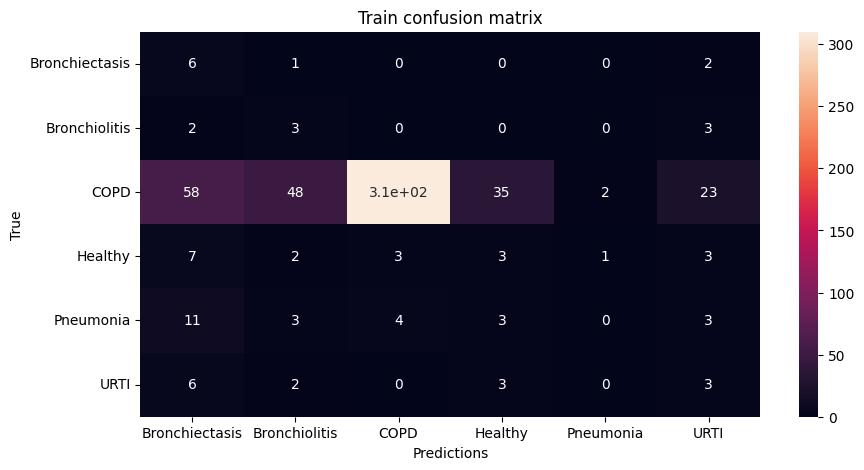

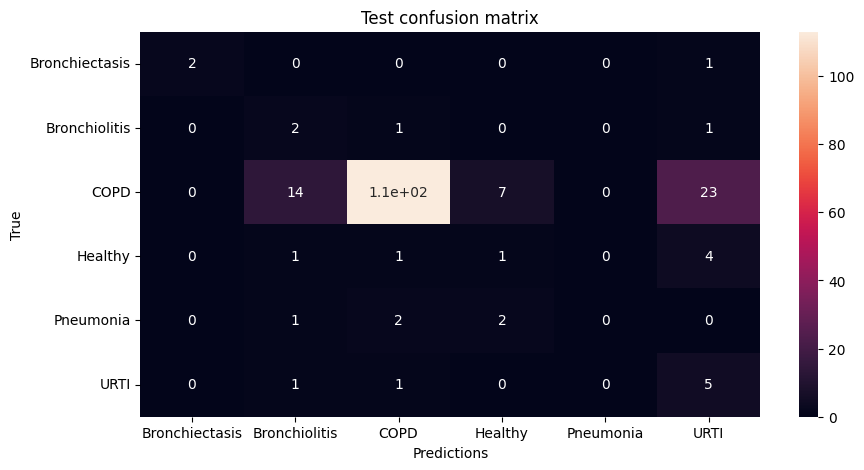


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 15:

Train Accuracy: 0.5190972222222222

Train Loss: 1.5815347631772358

Train F1 Score: 0.165036724259456

Test Accuracy: 0.5421195652173912

Test Loss: 1.604304571946462

Test F1 Score: 0.23290887723366419




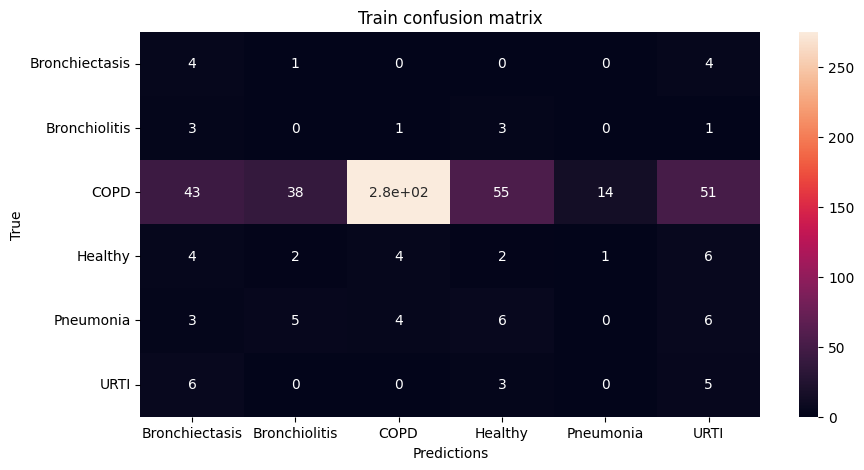

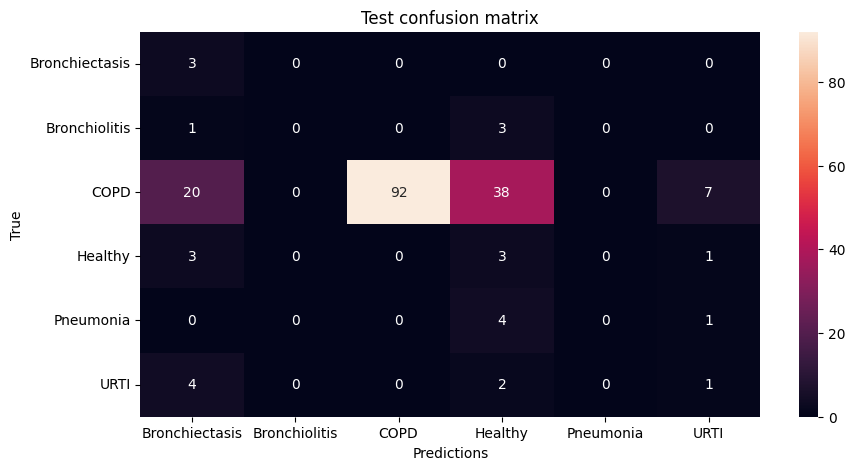


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 16:

Train Accuracy: 0.5711805555555556

Train Loss: 1.583443409866757

Train F1 Score: 0.17433292956815827

Test Accuracy: 0.5921648550724637

Test Loss: 1.5710997382799785

Test F1 Score: 0.2265967639784018




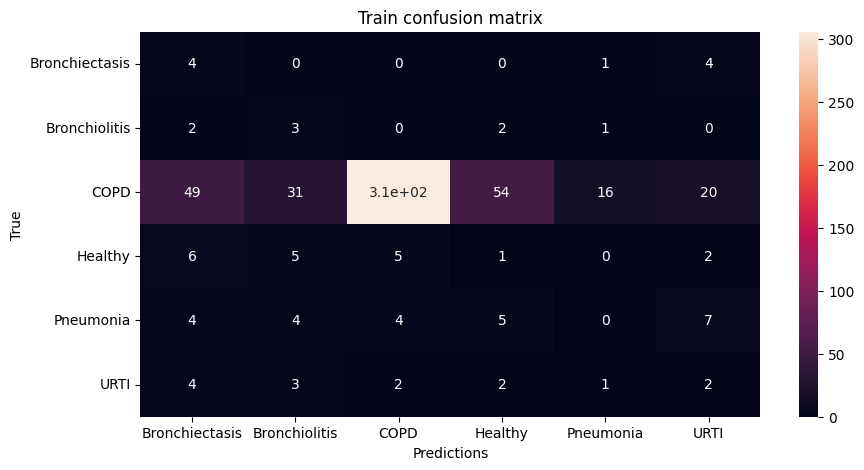

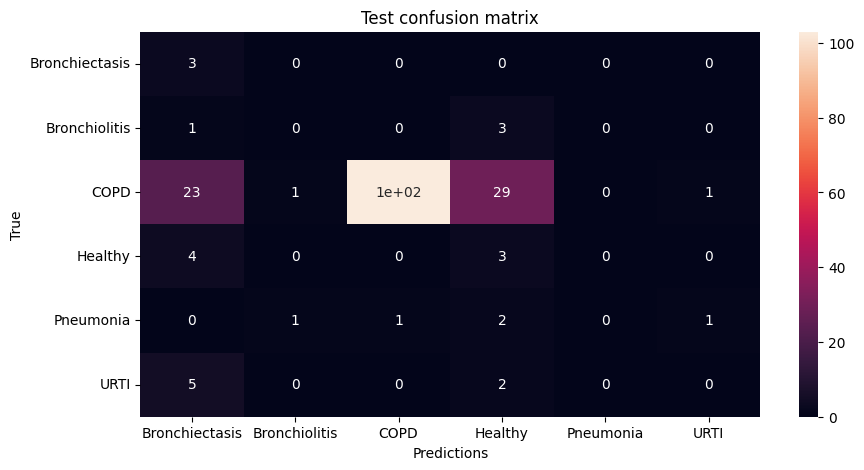


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 17:

Train Accuracy: 0.5428240740740741

Train Loss: 1.5720454653104146

Train F1 Score: 0.19114766104353798

Test Accuracy: 0.592391304347826

Test Loss: 1.5310272574424744

Test F1 Score: 0.2666912426551183




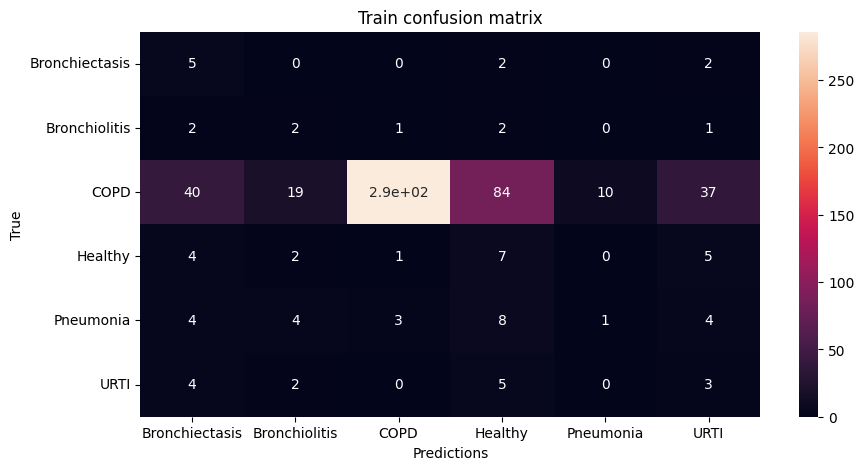

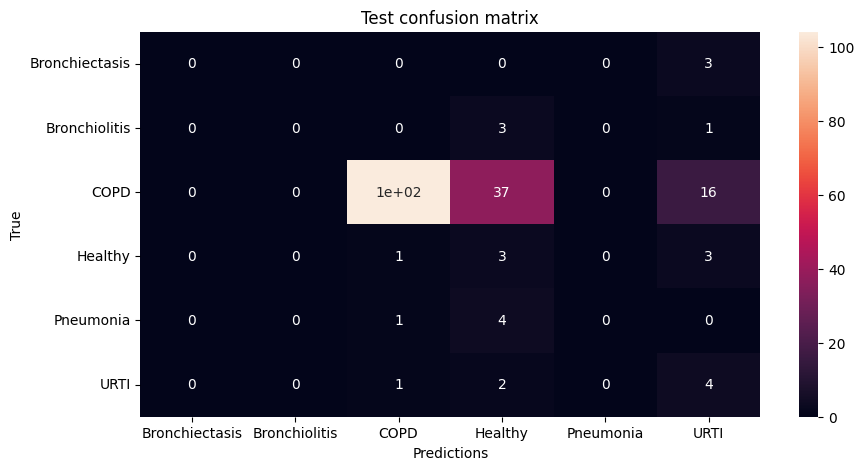


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 18:

Train Accuracy: 0.6296296296296297

Train Loss: 1.4790629545847576

Train F1 Score: 0.20607544523146418

Test Accuracy: 0.6222826086956522

Test Loss: 1.5231547753016155

Test F1 Score: 0.34079909572998685




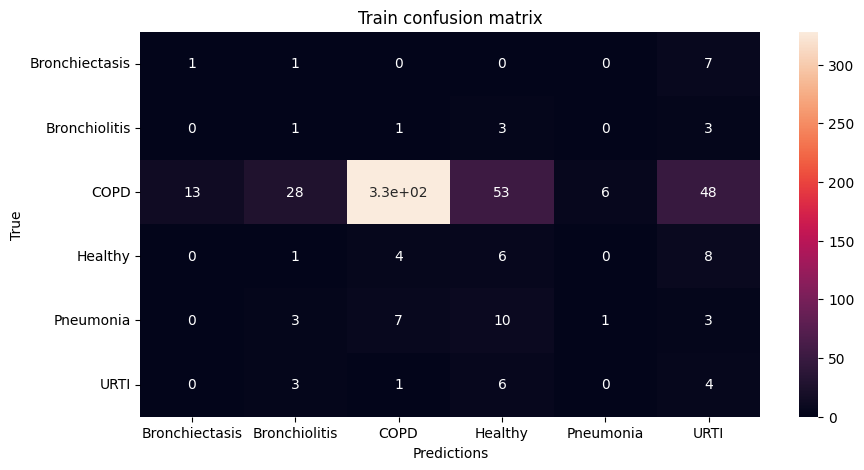

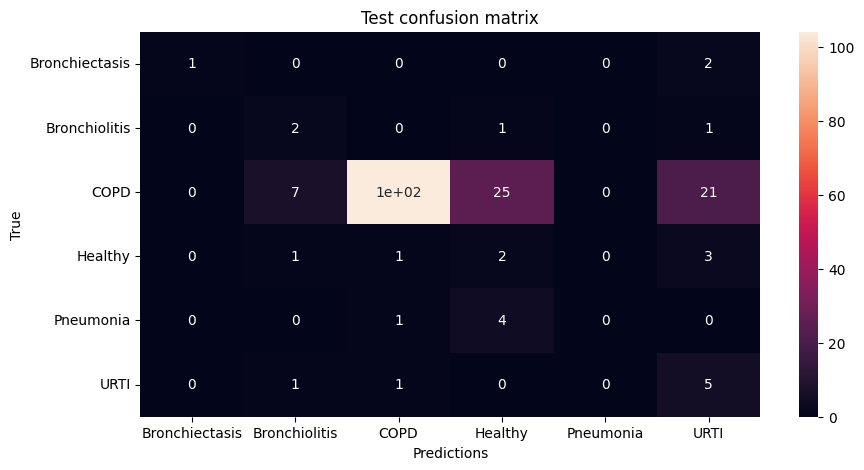


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 19:

Train Accuracy: 0.6255787037037037

Train Loss: 1.5683953497144911

Train F1 Score: 0.21753068475259674

Test Accuracy: 0.6170742753623188

Test Loss: 1.5510368744532268

Test F1 Score: 0.21151656657457352




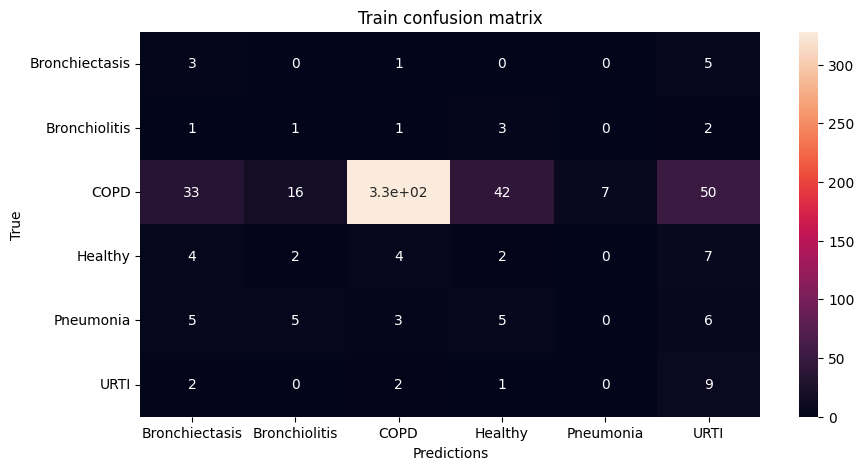

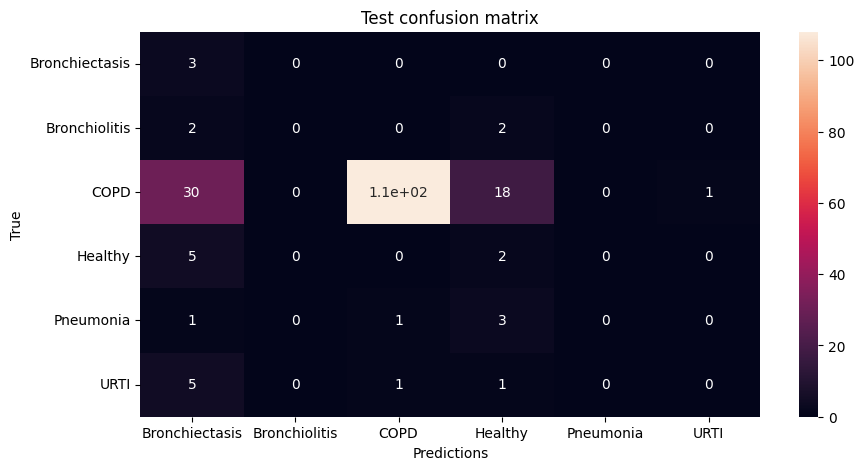


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 20:

Train Accuracy: 0.6423611111111112

Train Loss: 1.61150195201238

Train F1 Score: 0.1951550973786248

Test Accuracy: 0.6023550724637681

Test Loss: 1.5789896448453267

Test F1 Score: 0.21955333650112152




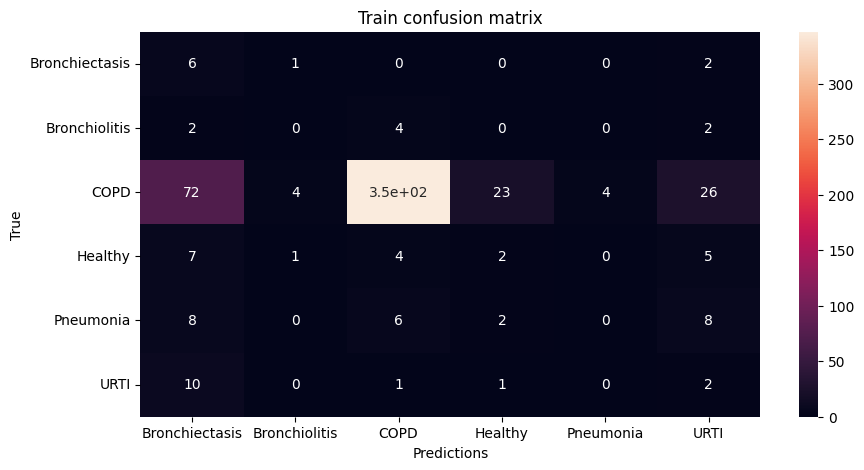

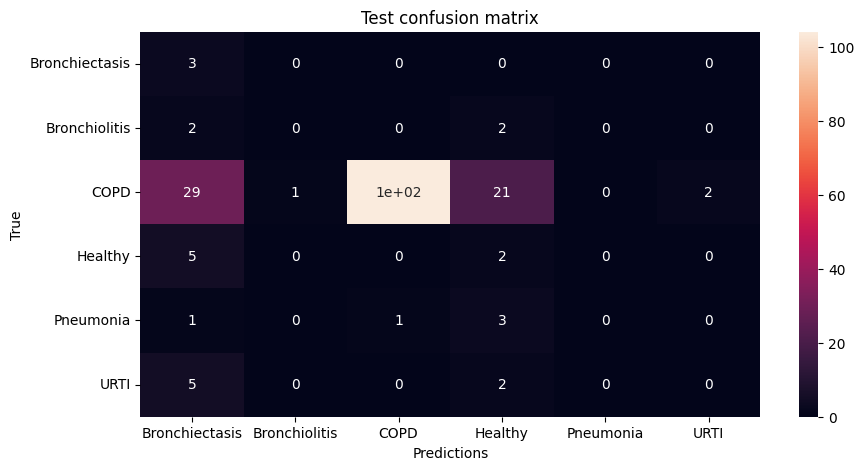


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 21:

Train Accuracy: 0.6487268518518519

Train Loss: 1.5097520881228976

Train F1 Score: 0.21552604188521704

Test Accuracy: 0.6764039855072465

Test Loss: 1.502687136332194

Test F1 Score: 0.24571652710437775




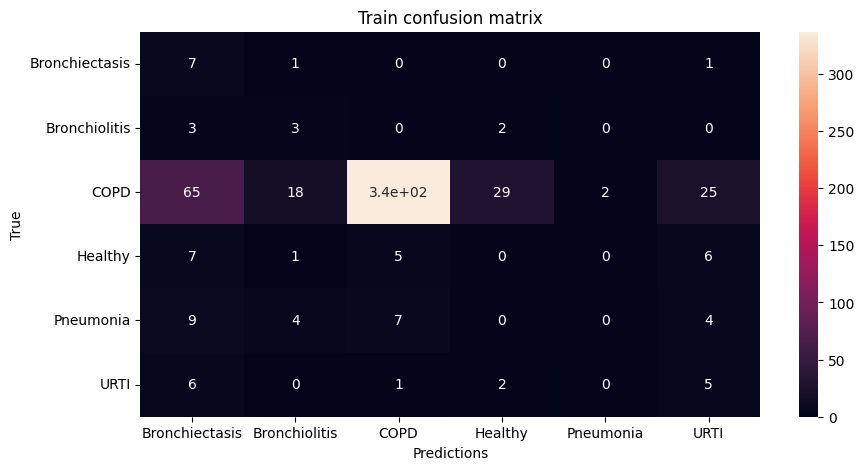

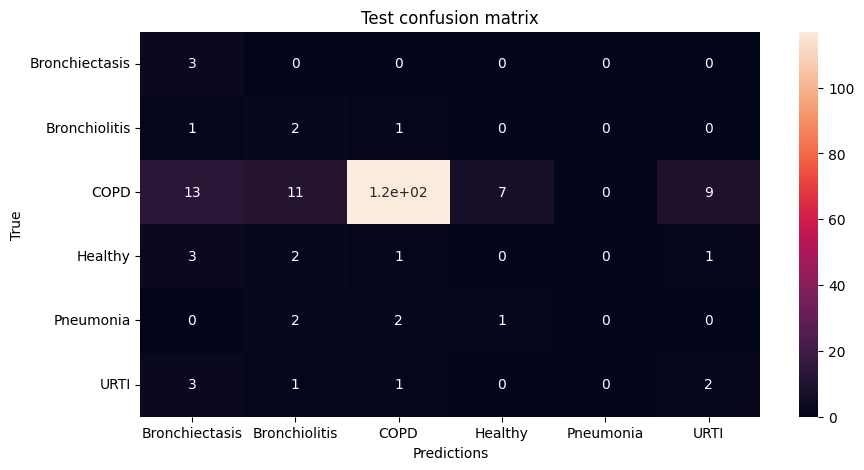


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 22:

Train Accuracy: 0.6585648148148148

Train Loss: 1.5571004748344421

Train F1 Score: 0.2337499058081044

Test Accuracy: 0.6159420289855072

Test Loss: 1.5173643032709758

Test F1 Score: 0.273897426823775




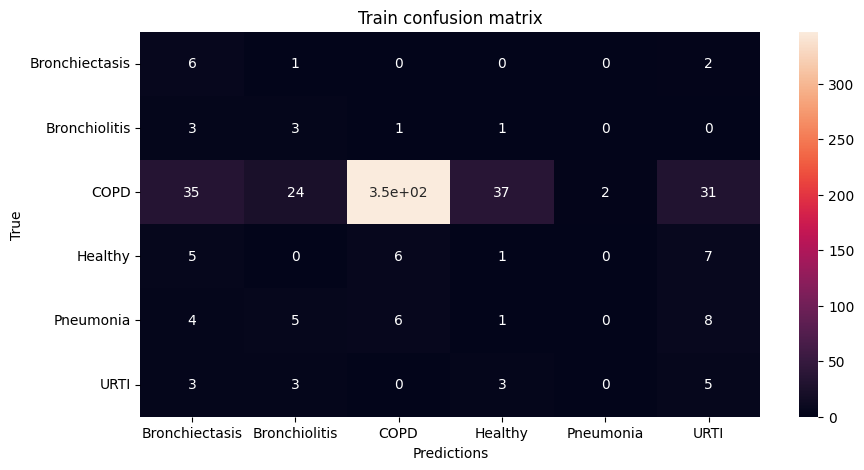

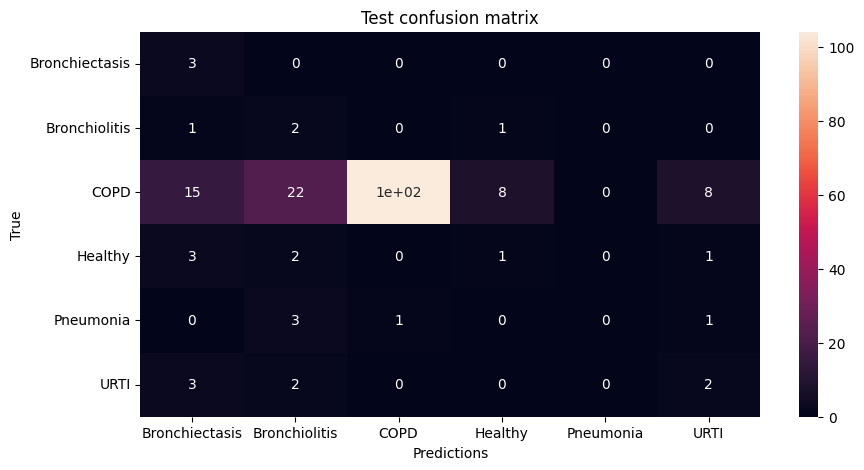


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 23:

Train Accuracy: 0.6371527777777778

Train Loss: 1.5390473935339186

Train F1 Score: 0.21379687471522224

Test Accuracy: 0.6856884057971014

Test Loss: 1.50326673189799

Test F1 Score: 0.23679194847742716




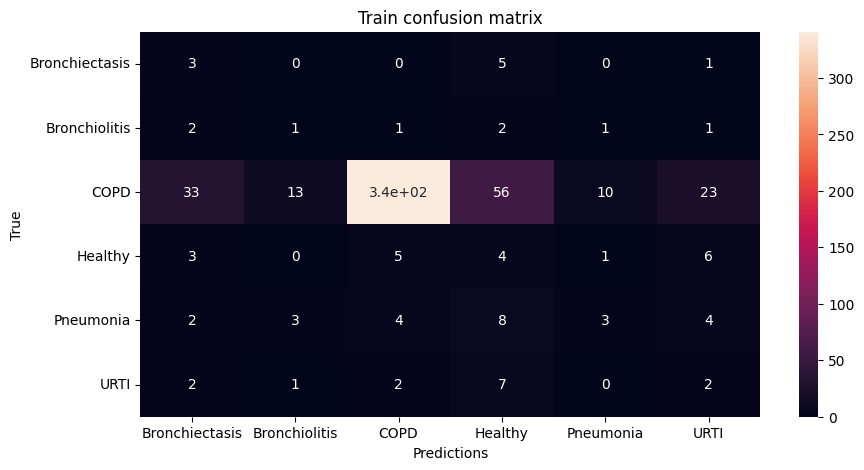

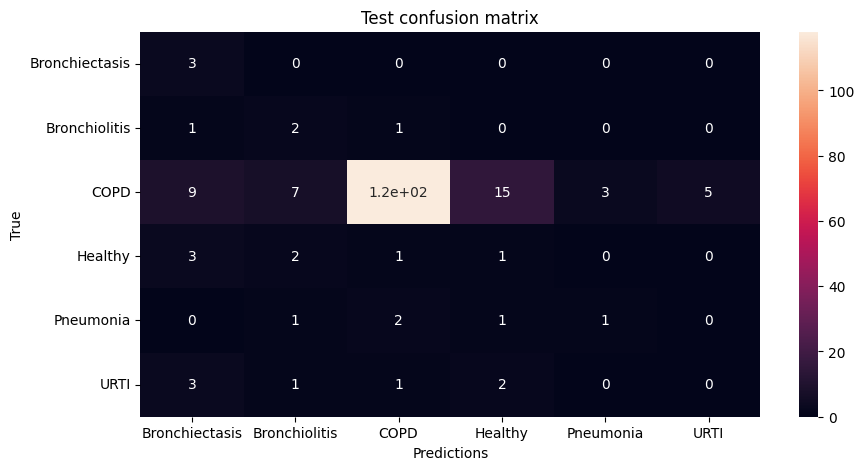


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 24:

Train Accuracy: 0.6336805555555556

Train Loss: 1.5432047247886658

Train F1 Score: 0.22359372882379425

Test Accuracy: 0.5942028985507246

Test Loss: 1.495248516400655

Test F1 Score: 0.2402190292874972




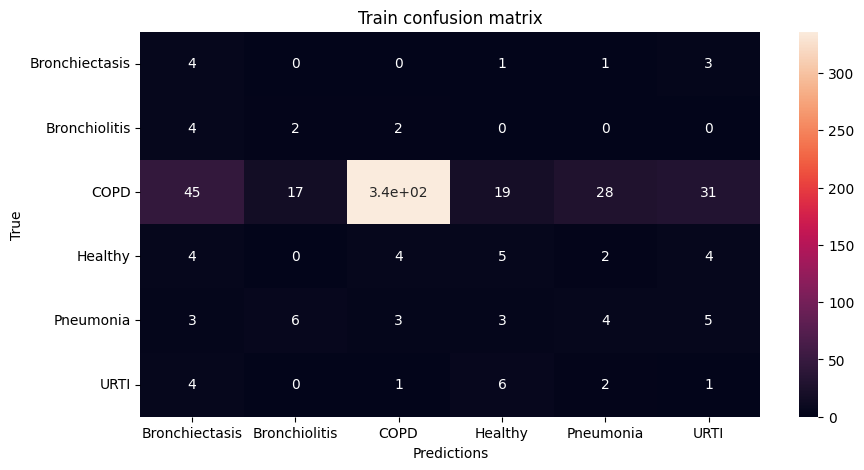

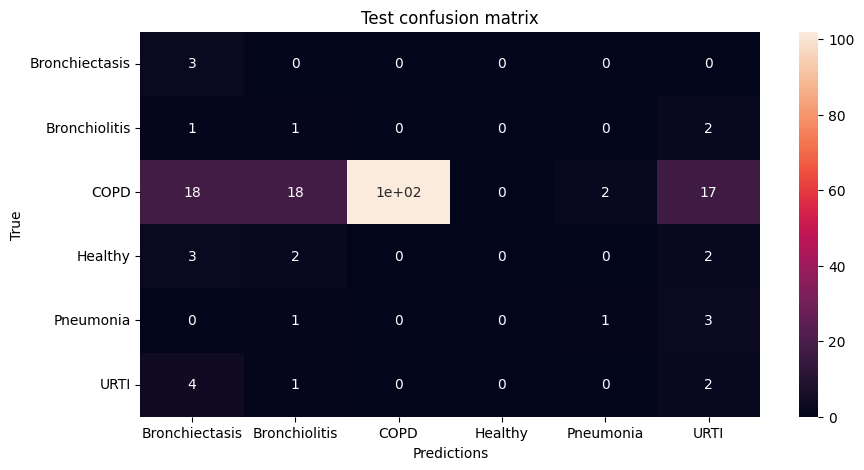


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 25:

Train Accuracy: 0.6261574074074074

Train Loss: 1.5684615307384067

Train F1 Score: 0.20569603269298872

Test Accuracy: 0.6222826086956522

Test Loss: 1.5454111099243164

Test F1 Score: 0.2147721548875173




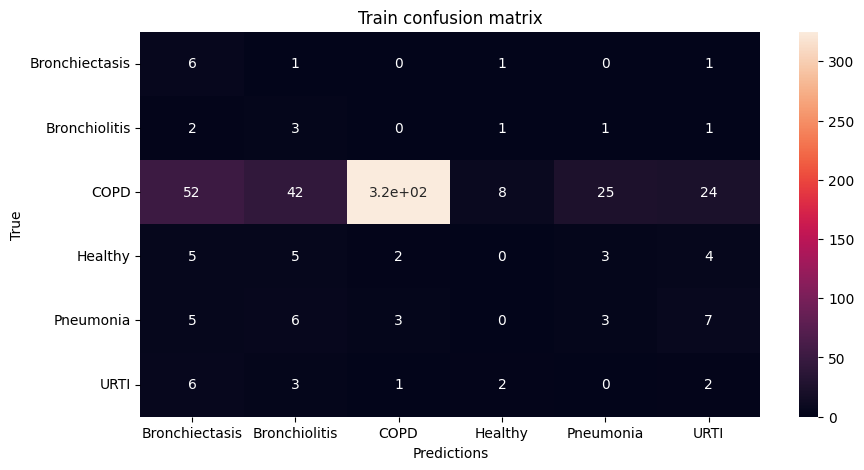

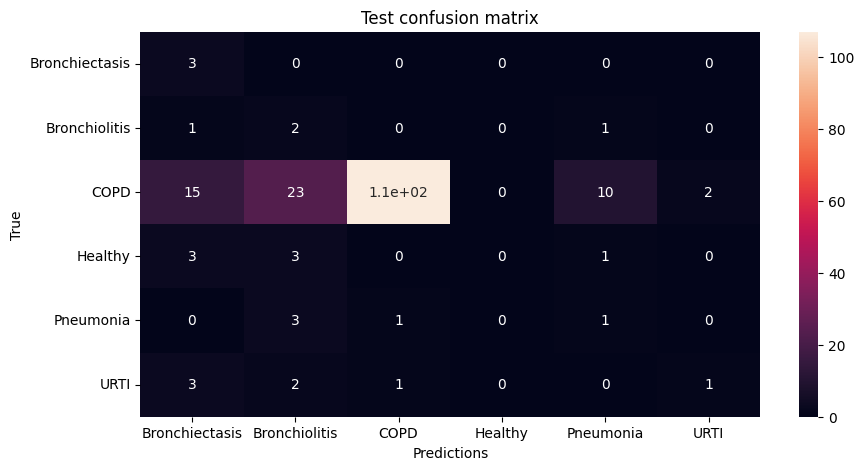


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 26:

Train Accuracy: 0.5862268518518519

Train Loss: 1.5442803369628058

Train F1 Score: 0.22385730346043906

Test Accuracy: 0.6098278985507246

Test Loss: 1.495236337184906

Test F1 Score: 0.25705037266016006




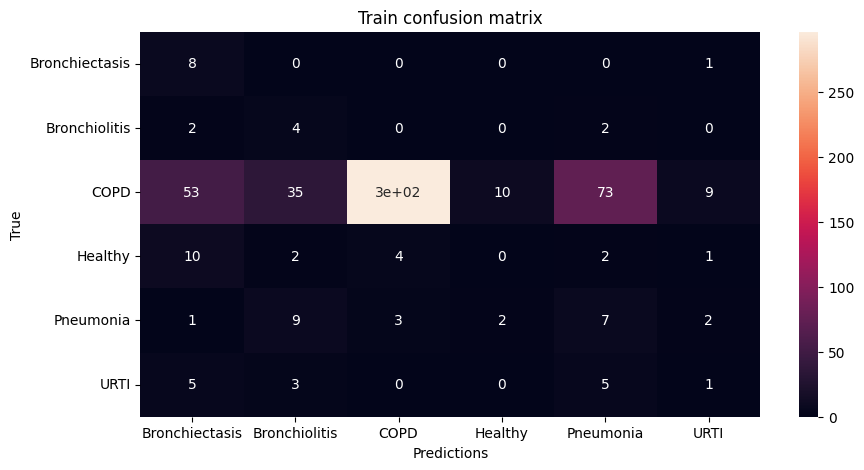

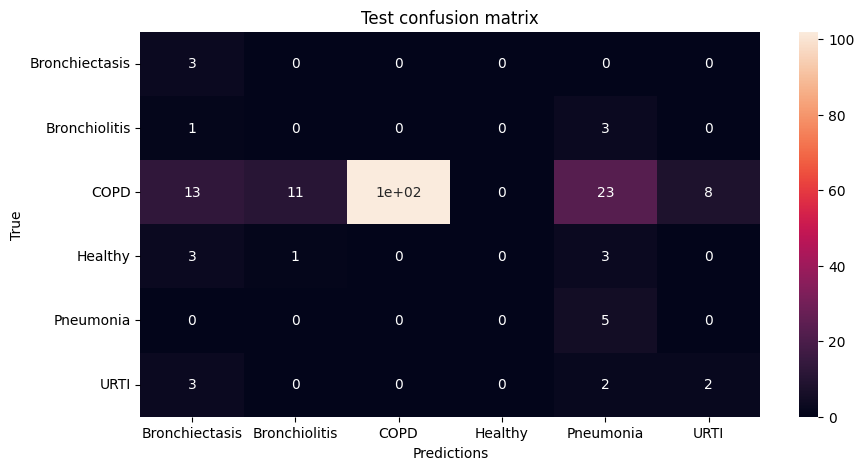


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 27:

Train Accuracy: 0.5775462962962963

Train Loss: 1.5405348340670268

Train F1 Score: 0.19730197721057469

Test Accuracy: 0.6358695652173912

Test Loss: 1.4854049285252888

Test F1 Score: 0.21357096234957376




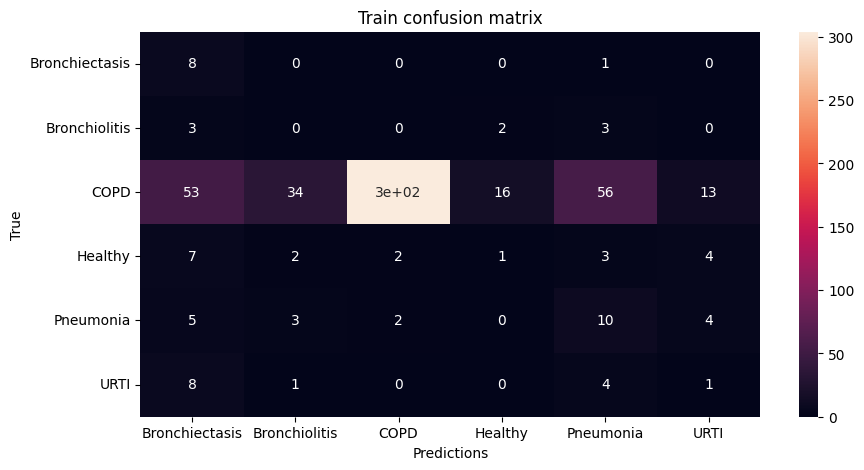

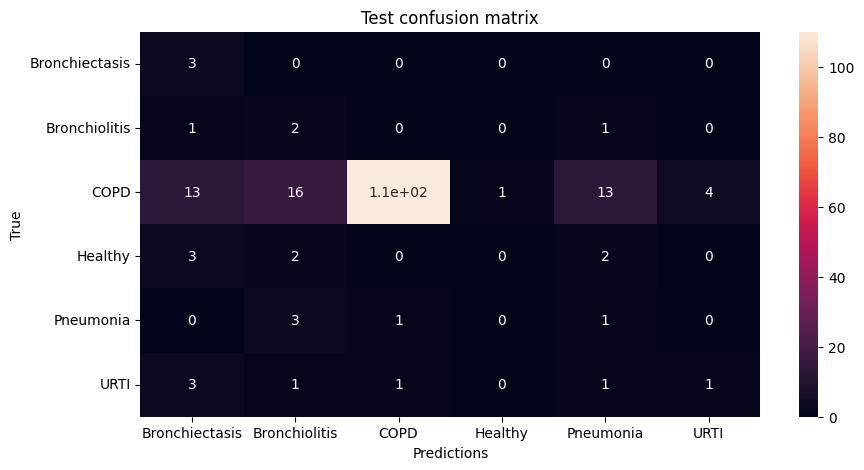


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 28:

Train Accuracy: 0.6782407407407408

Train Loss: 1.4771827028857336

Train F1 Score: 0.27218934231334263

Test Accuracy: 0.6471920289855072

Test Loss: 1.5641351342201233

Test F1 Score: 0.2211287741859754




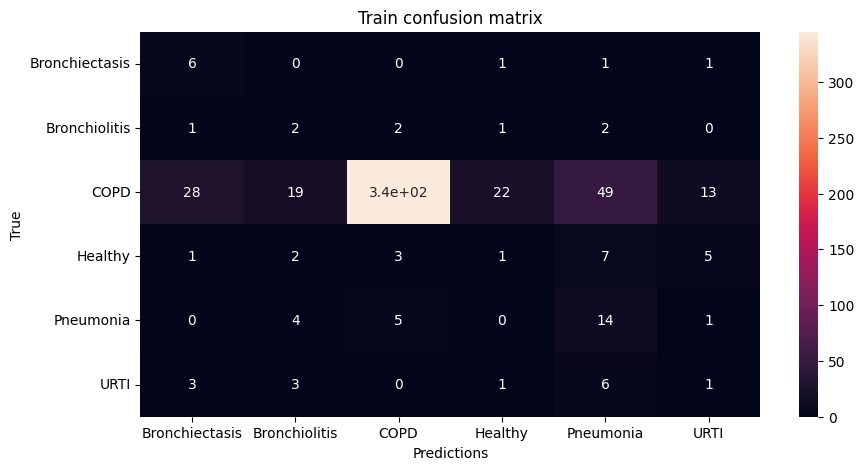

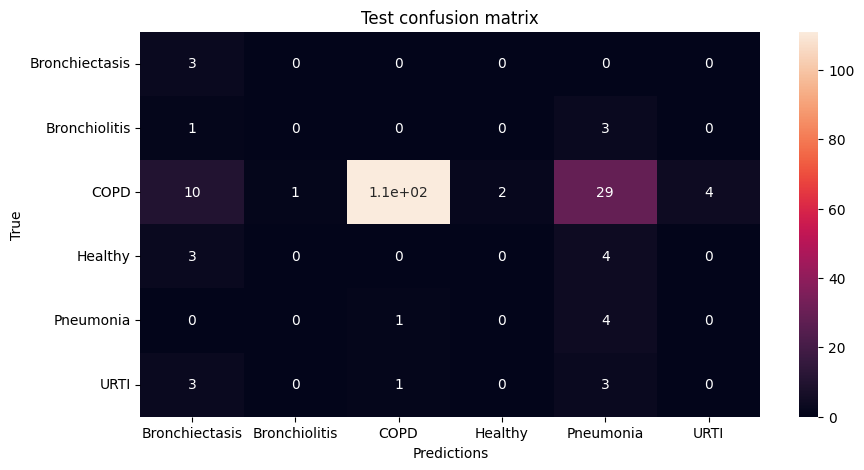


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 29:

Train Accuracy: 0.6168981481481481

Train Loss: 1.511838475863139

Train F1 Score: 0.22885123930043644

Test Accuracy: 0.6503623188405797

Test Loss: 1.4763757983843486

Test F1 Score: 0.22140571226676306




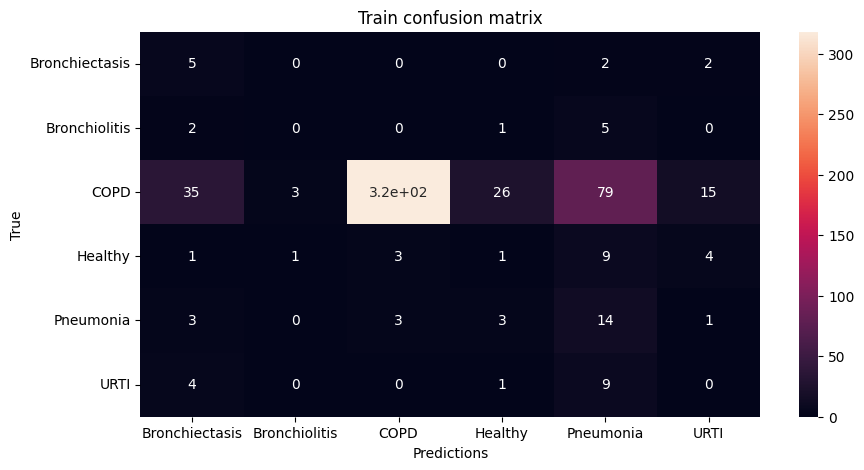

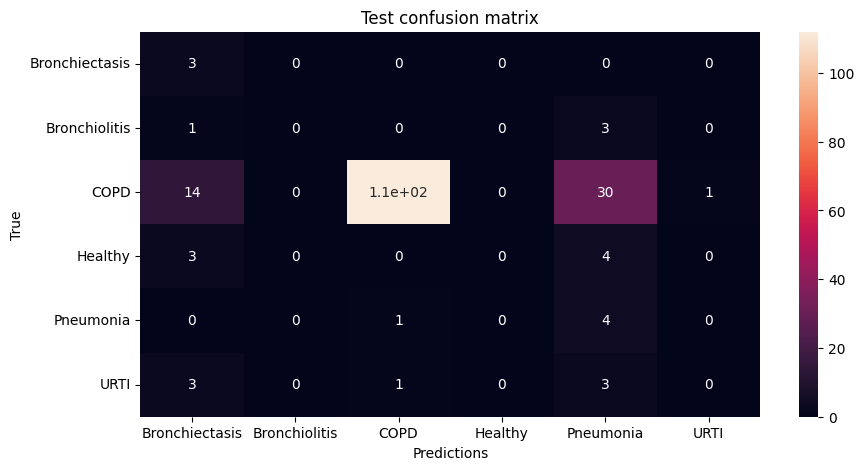


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 30:

Train Accuracy: 0.6168981481481481

Train Loss: 1.53181967470381

Train F1 Score: 0.24383837895260918

Test Accuracy: 0.5806159420289855

Test Loss: 1.5358051458994548

Test F1 Score: 0.22503714511791864




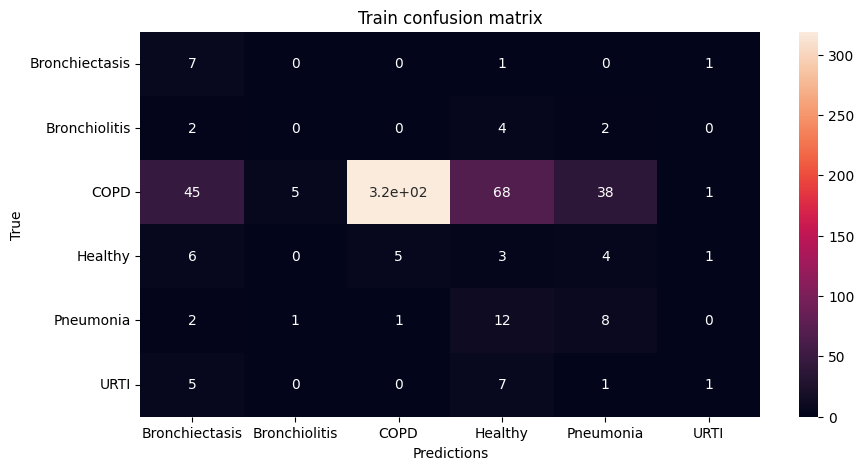

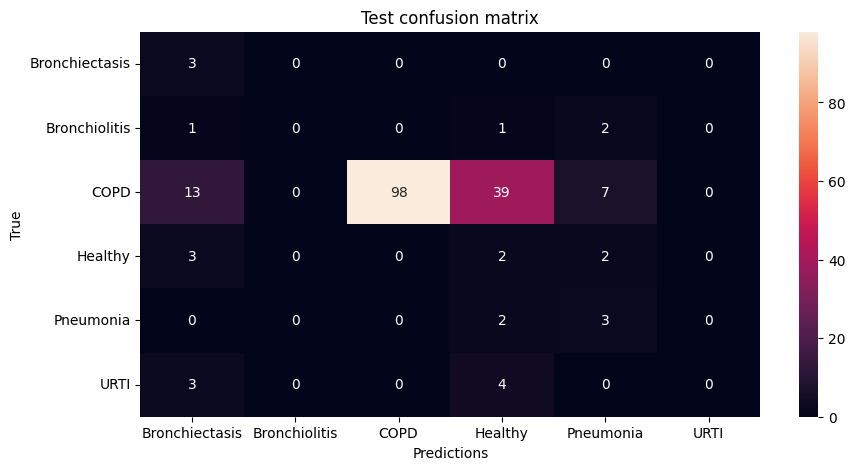

In [16]:
epochs=30
train_model(model,epochs)

### R & D

In [17]:
def mfccs_feature_exteraction(dir_):
    '''
        Extract MFCC feature from the Sound data from the audio data. 
        Augmentation of sound data by adding Noise, streaching and shifting.
        50 features are extracted from each audio data and used to train the model. 
        Also, we remove .wav files with patient_id 103,108, and 115 to solve data imbalance, because they have unique lables. 
        
        Args: dir_: Input directory to the Sound input file.
        
        Returns:
            X_data: Array of features extracted from the sound file.
            y_data: Array of target Labels.
    '''
    X_=[]
    y_=[]
    
    COPD=[]c
    copd_count=0
    
    data = train_ds.info_df
    features = 52
    
    for soundDir in (os.listdir(dir_)):
        if soundDir[-3:]=='wav'and soundDir[:3]!='103'and soundDir[:3]!='108'and soundDir[:3]!='115':

            p = list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0]
            if (p=='COPD'):
                if (soundDir[:6] in COPD) and copd_count<2:
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(soundDir[:6])
                    copd_count+=1
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
                    
                if (soundDir[:6] not in COPD):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(soundDir[:6])
                    copd_count=0
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
                
            if (p!='COPD'):
                if ((p == 'Bronchiectasis') or (p == 'Bronchiolitis')):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append('Bronchiolitis')
            
                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append('Bronchiolitis')

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append('Bronchiolitis')
                    
                    data_stretch = stretch(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiolitis')
                    
                    data_stretch_2 = stretch(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append('Bronchiolitis')
                    
                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiolitis')
                    
                else: 
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
            
                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append(p)

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append(p)
                    
                    data_stretch = stretch(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append(p)
                    
                    data_stretch_2 = stretch(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append(p)
                    
                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append(p)
                    
                    
                
    X_data = np.array(X_)
    y_data = np.array(y_)

    
    return X_data, y_data 

In [18]:
train_ds.__len__()+test_ds.__len__()+val_ds.__len__()

917

In [19]:
train_ds.classes

['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']

In [20]:
test_ds.classes

['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']

In [21]:
val_ds.classesdd

AttributeError: 'audio_dataset' object has no attribute 'classesdd'